# Dementia Evaluation

This notebook is used to evaluate the trained models.

In [1]:
import os, random, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import losses, optimizers, metrics
from tensorflow.keras import Input, Model, layers, callbacks, regularizers, models
from jarvis.train import custom, datasets, params
from jarvis.train.client import Client
from jarvis.utils.general import gpus, overload, tools as jtools
from jarvis.utils.display import imshow
from sklearn.metrics import classification_report

In [2]:
@overload(Client)
def preprocess(self, arrays, **kwargs):
    
    # --- Extract pre-calculated whole exam mu/sd and normalize
    arrays['xs']['dat'] = (arrays['xs']['dat'] - kwargs['row']['mu']) / kwargs['row']['sd']
    
    # --- Scale to 0/1 using 5/95 percentiles
    lower = np.percentile(arrays['xs']['dat'], 1)
    upper = np.percentile(arrays['xs']['dat'], 99)
    arrays['xs']['dat'] = arrays['xs']['dat'].clip(min=lower, max=upper)
    arrays['xs']['dat'] = (arrays['xs']['dat'] - lower) / (upper - lower)
    
    return arrays

In [93]:
# --- Load contrastive model
model = models.load_model("/home/mmorelan/proj/dementia/train/96x128/07/04/model.hdf5", compile=False)

In [94]:
# --- Extract autoencoder model from contrastive model
autoencoder = model.layers[3]

In [95]:
# --- Initialize client
AD_CLIENT_PATH = '/home/mmorelan/proj/dementia/yml/client-3d-96x128_AD_AV45_only.yml'
CN_CLIENT_PATH = '/home/mmorelan/proj/dementia/yml/client-3d-96x128_CN_AV45_only.yml'

client_AD = Client(AD_CLIENT_PATH, configs={'batch': {'fold': 0}})
client_CN = Client(CN_CLIENT_PATH, configs={'batch': {'fold': 0}})

In [96]:
# --- Create validation generator
test_AD_train, test_AD_valid = client_AD.create_generators(test=True)
test_CN_train, test_CN_valid = client_CN.create_generators(test=True)

In [97]:
# --- Aggregate all examples
xs = []
ys = []

for x, y in test_AD_valid:
    xs.append(x['dat'][0])
    ys.append(y['lbl'][0])
    
for x, y in test_CN_valid:
    xs.append(x['dat'][0])
    ys.append(y['lbl'][0])
    
xs = np.array(xs)
ys = np.array(ys)

[ 2021-08-25 16:49:31 ] [====================] 100.000% : Iterating | 000249    

In [55]:
def visualize_reconstruction(index):
    x = xs[np.newaxis, index, :]
    y = ys[np.newaxis, index, :]
    
    logits = autoencoder.predict(x)
    
    # Visualize reconstruction
    dec_logits = logits['dec']
    print(dec_logits.min(), dec_logits.max())
    imshow(dec_logits, figsize=(12, 12))
    plt.show()
    
    # Visualize ground truth
    print(x.min(), x.max())
    imshow(x, figsize=(12, 12))
    plt.show()

0.0038781762 0.93244916


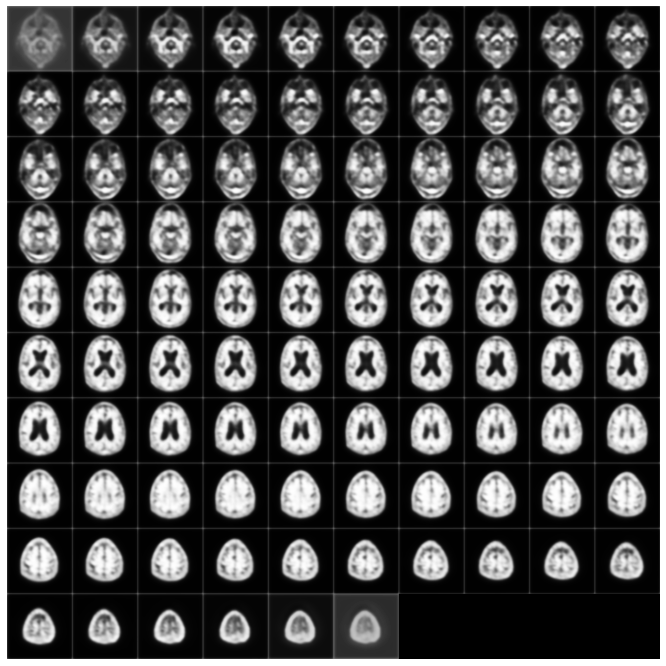

0.0 1.0


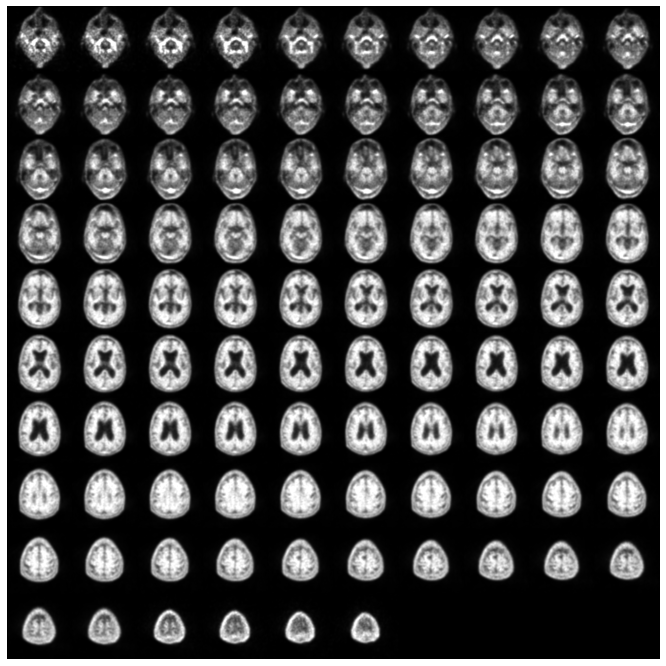

In [69]:
visualize_reconstruction(0)

In [98]:
logits = autoencoder.predict(xs)

In [99]:
def classification_metrics(logits, threshold=0.5):
    # --- Calculate metrics
    if type(logits) is dict:
        cls_logits = logits['cls']
        dec_logits = logits['dec']

    # --- Binarize probability predictions according to threshold
    pred = cls_logits
    pred[pred < threshold] = 0
    pred[pred >= threshold] = 1

    df = pd.DataFrame()
    df['pred'] = np.squeeze(pred)
    df['true'] = np.squeeze(ys)
    df['corr'] = df['pred'] == df['true']

    print("Accuracy:", df['corr'].mean())
    print(classification_report(y_true=df['true'], y_pred=df['pred']))

In [78]:
classification_metrics(logits)

Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       249
           1       0.50      0.82      0.62        51

    accuracy                           0.83       300
   macro avg       0.73      0.83      0.76       300
weighted avg       0.88      0.83      0.84       300



In [88]:
classification_metrics(logits)

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       249
           1       0.57      0.73      0.64        51

    accuracy                           0.86       300
   macro avg       0.75      0.81      0.78       300
weighted avg       0.88      0.86      0.87       300



In [100]:
# 07/04
classification_metrics(logits)

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       249
           1       0.52      0.80      0.63        51

    accuracy                           0.84       300
   macro avg       0.74      0.83      0.76       300
weighted avg       0.88      0.84      0.85       300

